In [3]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy.optimize import minimize

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
TOLERANCE = 1e-10

In [5]:
# load strategy data
daily_returns = pd.read_csv("../daily_returns.csv",index_col=0,parse_dates=True)

In [6]:
# code from https://quantdare.com/risk-parity-in-python/

def _allocation_risk(weights, covariances):

    # We calculate the risk of the weights distribution
    portfolio_risk = np.sqrt((weights * covariances * weights.T))[0, 0]

    # It returns the risk of the weights distribution
    return portfolio_risk


def _assets_risk_contribution_to_allocation_risk(weights, covariances):

    # We calculate the risk of the weights distribution
    portfolio_risk = _allocation_risk(weights, covariances)

    # We calculate the contribution of each asset to the risk of the weights
    # distribution
    assets_risk_contribution = np.multiply(weights.T, covariances * weights.T) \
        / portfolio_risk

    # It returns the contribution of each asset to the risk of the weights
    # distribution
    return assets_risk_contribution


def _risk_budget_objective_error(weights, args):

    # The covariance matrix occupies the first position in the variable
    covariances = args[0]

    # The desired contribution of each asset to the portfolio risk occupies the
    # second position
    assets_risk_budget = args[1]

    # We convert the weights to a matrix
    weights = np.matrix(weights)

    # We calculate the risk of the weights distribution
    portfolio_risk = _allocation_risk(weights, covariances)

    # We calculate the contribution of each asset to the risk of the weights
    # distribution
    assets_risk_contribution = \
        _assets_risk_contribution_to_allocation_risk(weights, covariances)

    # We calculate the desired contribution of each asset to the risk of the
    # weights distribution
    assets_risk_target = \
        np.asmatrix(np.multiply(portfolio_risk, assets_risk_budget))

    # Error between the desired contribution and the calculated contribution of
    # each asset
    error = \
        sum(np.square(assets_risk_contribution - assets_risk_target.T))[0, 0]

    # It returns the calculated error
    return error


def _get_risk_parity_weights(covariances, assets_risk_budget, initial_weights):

    # Restrictions to consider in the optimisation: only long positions whose
    # sum equals 100%
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1.0}, # sum to zero
                   {'type': 'ineq', 'fun': lambda x: x-0.05}) #positive

    # Optimisation process in scipy
    optimize_result = minimize(fun=_risk_budget_objective_error,
                               x0=initial_weights,
                               args=[covariances, assets_risk_budget],
                               method='SLSQP',
                               constraints=constraints,
                               tol=TOLERANCE,
                               options={'disp': False})

    # Recover the weights from the optimised object
    weights = optimize_result.x

    # It returns the optimised weights
    return weights


def get_weights(returns):

    # We calculate the covariance matrix
    covariances = returns.cov().values

    # The desired contribution of each asset to the portfolio risk: we want all
    # asset to contribute equally
    assets_risk_budget = [1 / returns.shape[1]] * returns.shape[1]

    # Initial weights: equally weighted
    init_weights = [1 / returns.shape[1]] * returns.shape[1]

    # Optimisation process of weights
    weights = \
        _get_risk_parity_weights(covariances, assets_risk_budget, init_weights)

    # Convert the weights to a pandas Series
    weights = pd.Series(weights, index=returns.columns, name='weight')

    # It returns the optimised weights
    #return weights
    return weights

In [7]:
window = 10

max_size = daily_returns.shape[0]

alloc = pd.DataFrame([get_weights(daily_returns.iloc[i:i+window]) for i in range(0,max_size-window)])

In [8]:
alloc.index = daily_returns.index[window:]

<AxesSubplot:xlabel='Date'>

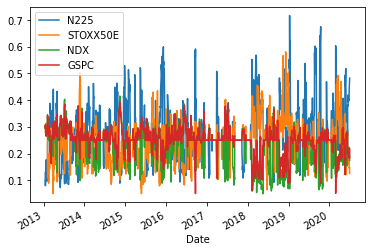

In [9]:
alloc.plot()

In [10]:
alloc.to_csv('../risk_parity.csv')